# Foundations of Logistic Regression

In [132]:
# Import Necessary Libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [133]:
p_value = np.random.uniform(low=0, high=1) # generate a random p-value between 0 and 1

print(p_value)

0.07771682756115839


#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

In [134]:
n = 100

# generate a sample of size n from a binomial distribution with number of trials = 1 and p = p_value
sample1 = np.random.binomial(n=1, p=p_value, size=n)
print(sample1)

# or directly use bernoulli.rvs from scipy.stats

sample2 = bernoulli.rvs(p=p_value, size=n)

print(sample2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

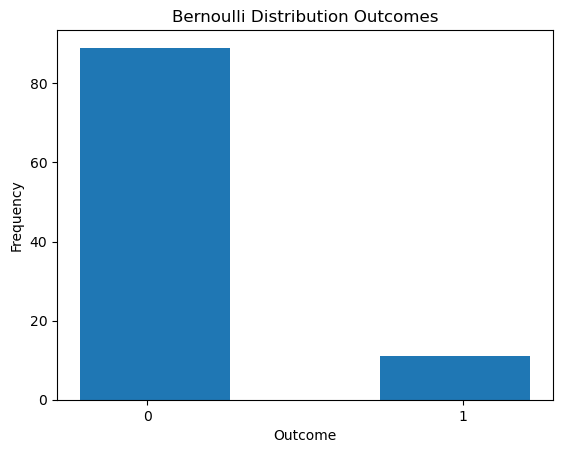

In [135]:
plt.hist(sample1, bins=3)
plt.title('Bernoulli Distribution Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.xticks([0.15, 0.85], ['0', '1'])
plt.show()


#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [136]:
estimate_p = np.mean(sample1) # estimate p by taking the mean of the sample
print(estimate_p)

0.11


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: 

Sampling error will cause uncertainty when use mean to estimate p value since any particular sample might not perfectly reflect the true p value. Also even with large number of trials, random chance can still lead sample mean to be slightly different from the true p value.

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

0.000979


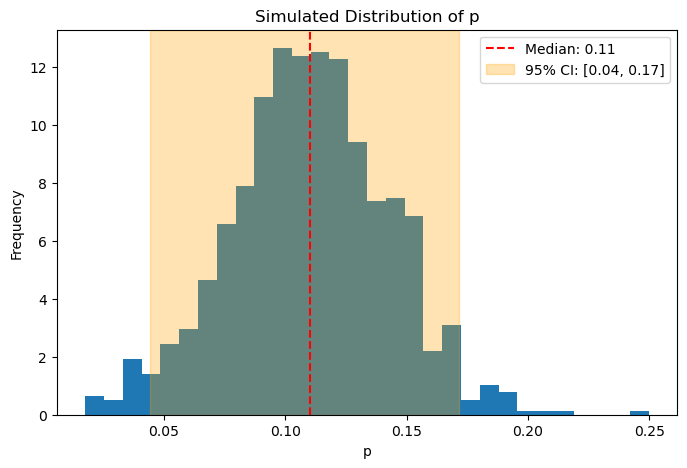

In [137]:
# MLE (Maximum Likelihood Estimation) is the same as mean of the sample for Bernoulli distribution

p_variance = estimate_p * (1 - estimate_p) / n # estimate the variance of the estimate p value, this variance shows how much the estimate p value varies across different samples
print(p_variance)

p_simulation = np.random.normal(loc=estimate_p, scale=np.sqrt(p_variance), size=1000) # simulate 1000 samples of size n from a normal distribution with mean = estimate_p and standard deviation = sqrt(p_variance)

lower_bound = np.percentile(p_simulation, 2.5) # lower bound of the 95% confidence interval
upper_bound = np.percentile(p_simulation, 97.5) # upper bound of the 95% confidence interval

p_median = np.percentile(p_simulation, 50) # median of the distribution

plt.figure(figsize=(8, 5))
plt.hist(p_simulation, bins=30, density=True)
plt.title('Simulated Distribution of p')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.axvline(p_median, color='red', linestyle='--', label=f'Median: {p_median:.2f}')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'95% CI: [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.legend()
plt.show()

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

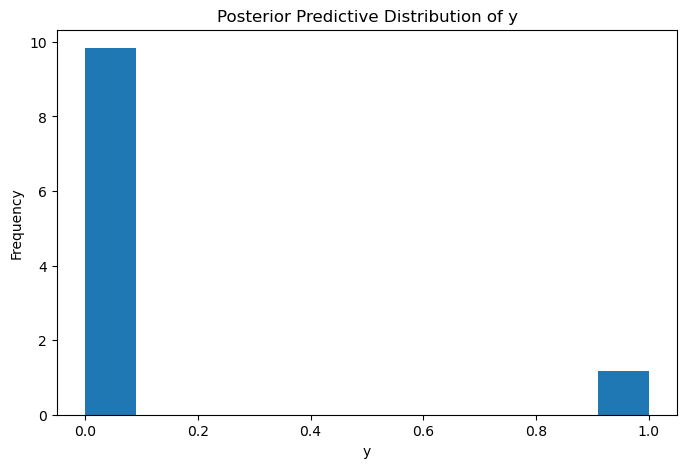

In [138]:
# Here we use the posterior predictive distribution of y to generate new samples for a hypothetical unobserved student

# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
for pi in p_simulation:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

plt.figure(figsize=(8, 5))
plt.hist(post_pred_sims, bins='auto', density=True)
plt.title('Posterior Predictive Distribution of y')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a) Load the National Survey on Drug Use and Health 2022 data, and check the number of respondents.

In [139]:
# Load data

df = pd.read_stata('NSDUH_2022.dta')

# Check dataset size
print(df.shape)

df.head()


(59069, 2605)


,QUESTID2,filedate,ANALWT2_C,VESTR_C,verep,PDEN10,COUTYP4,MAIIN102,AIIND102,AGE3,...,COSUTELE2,COSUAPTDL2,COSURXDL2,COSUSVHLT2,COHCTELE2,COHCAPTDL2,COHCRXDL2,COHCSVHLT2,langver,GQTYPE2
0,10000330,10/19/2023,298.004021,40030,2,1 - Segment in a CBSA with 1 million or more p...,1 - Large Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,6 - Respondent is 24 or 25 years old,...,1 - Yes,1 - Yes,1 - Yes,2 - No,1 - Yes,1 - Yes,1 - Yes,1 - Yes,2 - Spanish,
1,10000425,10/19/2023,2292.377696,40002,1,2 - Segm. in a CBSA with fewer than 1 million ...,2 - Small Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,9 - Respondent is between 35 and 49 years old,...,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,2 - No,2 - No,2 - No,2 - No,1 - English,
2,10002771,10/19/2023,216.604339,40041,2,1 - Segment in a CBSA with 1 million or more p...,1 - Large Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,6 - Respondent is 24 or 25 years old,...,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,1 - English,
3,10005250,10/19/2023,13828.218374,40012,2,2 - Segm. in a CBSA with fewer than 1 million ...,1 - Large Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,7 - Respondent is between 26 and 29 years old,...,2 - No,2 - No,2 - No,2 - No,2 - No,2 - No,2 - No,2 - No,1 - English,
4,10005432,10/19/2023,6282.612060,40037,1,2 - Segm. in a CBSA with fewer than 1 million ...,2 - Small Metro,2 - Segment not in an American Indian area,2 - Census block not in an American Indian area,10 - Respondent is between 50 and 64 years old,...,3 - Does not apply,3 - Does not apply,3 - Does not apply,3 - Does not apply,2 - No,1 - Yes,2 - No,2 - No,1 - English,


#### b) Subset the dataset to include only people who `study full-time` in the NSDUH (Hint: in the codebook look for variable `edufulpar`)

In [140]:
# Focus on smokers only 
# Smoking history variable: cigever
print(df['edufulpar'].value_counts())

edufulpar
99 - LEGITIMATE SKIP                38897
1 - FULL-TIME                       14976
2 - PART-TIME                        2513
98 - BLANK                           1986
94 - DON T KNOW                       395
97 - REFUSED                          296
85 - BAD DATA Logically assigned        6
Name: count, dtype: int64


In [141]:
# Keep only people who study full-time
df = df[df['edufulpar'] == '1 - FULL-TIME']

print(df.shape)

(14976, 2605)


#### c) Define the outcome of interest as 1 if the person have vaped an e-cigarette, 0 otherwise. (Hint: in the codebook look for variable `nicvapever` )

In [142]:
print(df['nicvapever'].value_counts())

nicvapever
2 - No             10993
1 - Yes             3976
94 - DON T KNOW        4
97 - REFUSED           3
Name: count, dtype: int64


#### d) Create a design matrix including age (catage), military service (service), health (HEALTH2), gender (irsex), income (irpinc3), employement (wrkdpstwk) # Turn these features into a numeric matrix so we can use them to fit the model. 

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [143]:
# Prepare variables

# Keep only people who ever smoked a cigarette
df = df[df['cigever'] == '1 - Yes']

# Age
def age_sort(x):
    if x == '1 - 12-17 Years Old':
        return 1
    elif x == '2 - 18-25 Years Old':
        return 2
    elif x == '3 - 26-34 Years Old':
        return 3
    elif x == '4 - 35 or Older':
        return 4
    else:
        return 0
    
age = df['catage'].apply(age_sort)
# print(age.value_counts())

# Military service
def military_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
    
military = df['service'].apply(military_sort)
# print(military.value_counts())

# Health
def health_sort(x):
    if x == '1 - Excellent':
        return 4
    elif x == '2 - Very Good':
        return 3
    elif x == '3 - Good':
        return 2
    elif x == '4 - Fair/Poor':
        return 1
    else:
        return 0
    
health = df['HEALTH2'].apply(health_sort)
# print(health.value_counts())

# Gender
def gender_sort(x):
    if x == '1 - Male':
        return 1
    elif x == '2 - Female':
        return 0
    
gender = df['irsex'].apply(gender_sort)
# print(gender.value_counts())

# Income
def income_sort(x):
    if x == '1 - Less than $10,000':
        return 1
    elif x == '2 - $10,000 - $19,999':
        return 2
    elif x == '3 - $20,000 - $29,999':
        return 3
    elif x == '4 - $30,000 - $39,999':
        return 4
    elif x == '5 - $40,000 - $49,999':
        return 5
    elif x == '6 - $50,000 - $74,999':
        return 6
    elif x == '7 - $75,000 or more':
        return 7
    else:
        return 0
income = df['IRPINC3'].apply(income_sort)
# print(income.value_counts())

# Employment
def employment_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
employment = df['wrkdpstwk'].apply(employment_sort)
# print(employment.value_counts())

vaper = df['nicvapever'].apply(lambda x: 1 if x == '1 - Yes' else 0)
# Create design matrix 
variables = pd.DataFrame({
    'Cigarette': cig,
    'Age': age,
    'Military': military,
    'Health' : health,
    'Gender' : gender,
    'Income' : income,
    'Employment' : employment,
    'Vaper' : vaper
})

variables = variables.dropna()

X = variables[['Age', 'Military', 'Health', 'Gender', 'Income', 'Employment']].astype(int)
Y= variables['Vaper'].astype(int)

# Display the first few rows of the DataFrame
print(X.head())
print(Y.head())

     Age  Military  Health  Gender  Income  Employment
41     2         0       4       0       1           1
57     3         0       3       0       4           0
78     3         0       3       1       2           1
127    1         0       4       1       1           0
142    2         0       3       0       7           1
41     1
57     1
78     0
127    1
142    0
Name: Vaper, dtype: int32


#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [144]:
# Converts Y into a NumPy array and add X to it
YX = np.hstack((np.array(Y)[:, np.newaxis], X))
# YX = YX[~np.any(np.isnan(YX), axis=1)] # remove rows with NaN values

# Examine the correlation between covariates and outcome (outcome is the first column)
np.corrcoef(YX.T)

array([[ 1.        , -0.35418551, -0.03924186,  0.00458942,  0.01704505,
        -0.23020829,  0.00109183],
       [-0.35418551,  1.        ,  0.20164277, -0.02579295, -0.03516421,
         0.54421171,  0.19512199],
       [-0.03924186,  0.20164277,  1.        , -0.00710656,  0.1225477 ,
         0.22271398,  0.04363739],
       [ 0.00458942, -0.02579295, -0.00710656,  1.        ,  0.11199186,
         0.03446591,  0.06063484],
       [ 0.01704505, -0.03516421,  0.1225477 ,  0.11199186,  1.        ,
         0.03609083, -0.02146551],
       [-0.23020829,  0.54421171,  0.22271398,  0.03446591,  0.03609083,
         1.        ,  0.26246661],
       [ 0.00109183,  0.19512199,  0.04363739,  0.06063484, -0.02146551,
         0.26246661,  1.        ]])

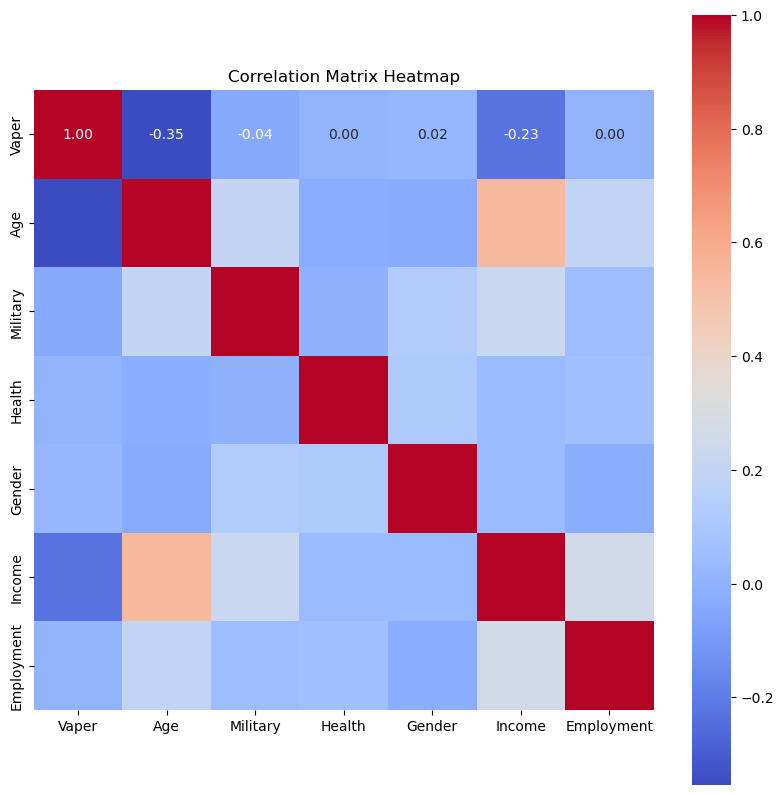

In [145]:
# Combine X and Y into a single DataFrame
combined_df = pd.concat([Y, X], axis=1)

# Compute the correlation matrix
corr_matrix = combined_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [146]:
# Add an intercept to the model
X_with_intercept = sm.add_constant(X)

model = sm.Logit(Y, X_with_intercept).fit()

Optimization terminated successfully.
         Current function value: 0.426411
         Iterations 6


#### g) Get summary of regression output.

In [147]:
# Get summary results
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                 2145
Model:                          Logit   Df Residuals:                     2138
Method:                           MLE   Df Model:                            6
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:                  0.1296
Time:                        02:49:09   Log-Likelihood:                -914.65
converged:                       True   LL-Null:                       -1050.8
Covariance Type:            nonrobust   LLR p-value:                 6.957e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5721      0.254     14.071      0.000       3.075       4.070
Age           -0.8859      0.071    -12.415      0.000      -1.026      -0.746
Military       0.4563      0.285      1.599      0.1

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [148]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

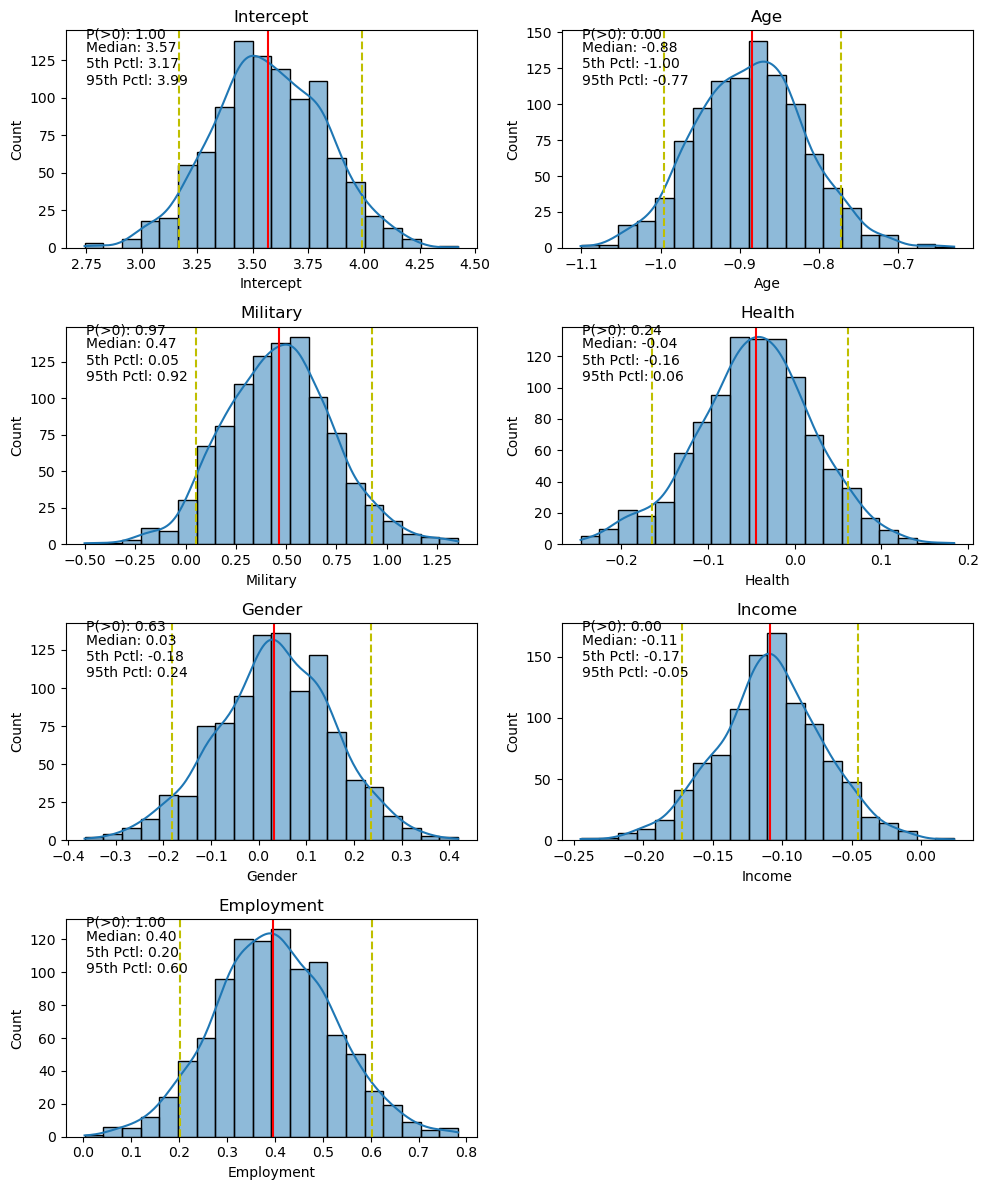

In [149]:
simulated_betas_df = pd.DataFrame(simulated_betas, columns=['Intercept', 'Age', 'Military', 'Health', 'Gender', 'Income', 'Employment'])

# Define subplot grid
n_rows = (simulated_betas_df.shape[1] + 1) // 2  # 2 graphs per row
fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through the columns and plot histograms on the subplots
for i, col in enumerate(simulated_betas_df.columns):
    sns.histplot(simulated_betas_df[col], kde=True, ax=axes[i], bins=20)
    
    # Calculate the median, 5th, and 95th percentiles
    median_val = simulated_betas_df[col].median()
    p5_val = simulated_betas_df[col].quantile(0.05)
    p95_val = simulated_betas_df[col].quantile(0.95)
    prob_positive = np.mean(simulated_betas > 0, axis=0)
    
    # Annotate the histogram with vertical lines and labels for median and percentiles
    axes[i].axvline(x=median_val, color='r', linestyle='-')
    axes[i].axvline(x=p5_val, color='y', linestyle='--')
    axes[i].axvline(x=p95_val, color='y', linestyle='--')
    
    # Add text annotation for probability above 0
    axes[i].text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=axes[i].transAxes, verticalalignment='bottom', fontsize=10)
    
    # Create a label that includes the numeric values for the lines
    label_text = f'Median: {median_val:.2f}\n5th Pctl: {p5_val:.2f}\n95th Pctl: {p95_val:.2f}'
    axes[i].text(0.05, 0.95, label_text, transform=axes[i].transAxes, verticalalignment='top')
    
    axes[i].set_title(col)

# Hide any unused axes
for i in range(len(simulated_betas_df.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### i) Now let's practice making predictions from this model that we learned. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [150]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(np.dot(simulated_betas, average_X))

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times if a person vapes e-cigarette).

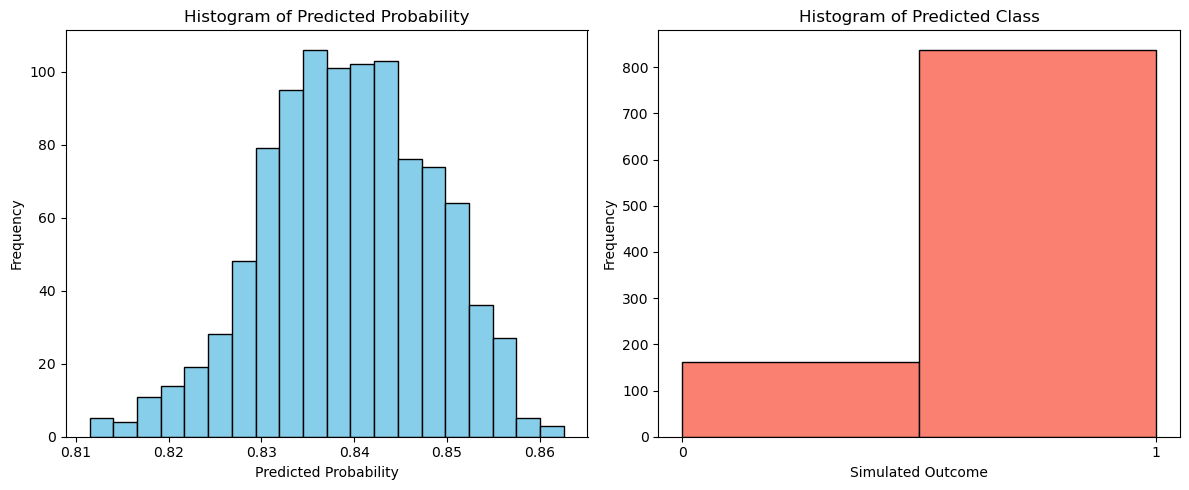

In [151]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = np.random.binomial(1, new_predicted_probs)

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
